In [2]:
import numpy as np
import import_ipynb
#import numpy.linalg as LA
#import LMM as lmm
import random
import time
import os
import pandas as pd
from scipy.io import mmread
import scipy.sparse as sp
import matplotlib.pyplot as plt
from IPython.display import Image
import scanpy as sc
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.patches as mpatches
from statsmodels.graphics.api import abline_plot
import seaborn as sns
import umap
from numpy import eye, asarray, dot, sum, diag
from numpy.linalg import svd

import statsmodels.formula.api as smf
import pandas

np.random.seed(10)

def get_binary_covariate(covariate, covariate_level, data):
    covariate_list = np.zeros((data.obs.shape[0]))
    for i in range(data.obs.shape[0]):
        ### select the ith element of 
        if data.obs[[covariate]].squeeze()[i] == covariate_level:
            covariate_list[i] = 1
    return covariate_list


def get_design_mat(a_metadata_col, data):
    ### given a column of the dat object metadata, return a onehot encoded design matrix
    column_levels = data.obs[a_metadata_col].unique()
    dict_covariate = {}
    for column_level in column_levels:
        print(column_level)
        dict_covariate[column_level] = get_binary_covariate(a_metadata_col, column_level, data)

    #### stack colummns of dict_covariate 
    x = np.column_stack((dict_covariate[column] for column in column_levels))
    return x



def varimax(Phi, gamma = 1.0, q = 100, tol = 1e-6):
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in range(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d_old!=0 and d/d_old < 1 + tol: break
    Lambda = dot(Phi, R)

    return {'rotloadings':Lambda, 'rotmat':R}


In [3]:
#### import the immune subpopulation of the rat samples
data = sc.read('/home/delaram/scLMM/sc_mixology/scMix_3cl_merged.h5ad') ## attributes removed
#data = sc.read('/home/delaram/scLMM/sc_mixology/scMix_5cl_merged.h5ad') ## attributes removed


data.var_names_make_unique()
# a.obs['orig.ident'].head()
### renaming the meta info column names: https://github.com/theislab/scvelo/issues/255
data.__dict__['_raw'].__dict__['_var'] = data.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})

data_numpy = data.X.toarray()
cell_sums = np.sum(data_numpy,axis=1) # row sums - library size
gene_sums = np.sum(data_numpy,axis=0) # col sums - sum reads in a gene
gene_vars = np.var(data_numpy, axis=0)
data_numpy = data_numpy[:,gene_sums != 0]

### print head pf the data.obs
print(data.obs.head())

#### sample metadata
y_cell_line = data.obs.cell_line_demuxlet
y_sample = data.obs.sample
y_sample = data.obs[['sample']].squeeze()

## working with the rat data
num_cells = data_numpy.shape[0]
num_genes = data_numpy.shape[1]

### print the dimensions of the data - 1401 28335
print(num_cells, num_genes)


num_genes = 5000

#### select num_genes genes based on variance
### calculate the variance for each gene
gene_vars = np.var(data_numpy, axis=0)
### select the top num_genes genes with the highest variance
gene_idx = np.argsort(gene_vars)[::-1][0:num_genes]
### subset the data matrix to the top num_genes genes
data_numpy = data_numpy[:, gene_idx]

#### randomly select num_genes genes
#gene_idx = random.sample(range(0, data_numpy.shape[1]), num_genes)
#data_numpy = data_numpy[:, gene_idx]

y = data_numpy

print(y_sample.unique())
print(y_cell_line.unique())



                   orig.ident  nCount_originalexp  nFeature_originalexp  \
sc_10X_CELL_000001       CELL            266379.0                 10770   
sc_10X_CELL_000002       CELL            248501.0                 11155   
sc_10X_CELL_000003       CELL            250649.0                 10682   
sc_10X_CELL_000004       CELL            249556.0                 10785   
sc_10X_CELL_000005       CELL            243926.0                 10435   

                    unaligned  aligned_unmapped  mapped_to_exon  \
sc_10X_CELL_000001     167234              8341          526950   
sc_10X_CELL_000002     171821             10047          513676   
sc_10X_CELL_000003     174510              8608          513021   
sc_10X_CELL_000004     158346              7796          504676   
sc_10X_CELL_000005     159070              6968          486645   

                    mapped_to_intron  ambiguous_mapping  mapped_to_ERCC  \
sc_10X_CELL_000001             40991              21392               0

In [4]:
#### adding a column to data object for protocol
## empty numpy array in length of the number of cells
y_protocol = np.empty((y.shape[0]), dtype="S10")

for i in range(y.shape[0]):
    if data.obs['sample'][i] in ['sc_10x', 'sc_10X']:
        y_protocol[i] = 'sc_10X'

    elif data.obs['sample'][i] == 'Dropseq':
        y_protocol[i] = 'Dropseq'
        
    else:
        y_protocol[i] = 'CELseq2'

print(y_protocol)
print(len(y_protocol))
data.obs['protocol'] = y_protocol
y_protocol = pd.Series(y_protocol)
y_protocol.unique()

[b'sc_10X' b'sc_10X' b'sc_10X' ... b'Dropseq' b'Dropseq' b'Dropseq']
1401


array([b'sc_10X', b'CELseq2', b'Dropseq'], dtype='|S10')

In [5]:
#### Design matrix : Intercept + Depth + protocol

#x_batch = get_design_mat('batch', data)
x_protocol = get_design_mat('protocol', data)
#x_cell_line = get_design_mat('cell_line', data)
#x = np.column_stack((data.obs.nCount_originalexp, x_protocol)) #, x_batch
#x = sm.add_constant(x) ## adding the intercept

x = np.column_stack((np.ones(y.shape[0]), np.array(data.obs.nCount_originalexp)))
print(x[0:3,:])
print(x.shape)

b'sc_10X'
b'CELseq2'
b'Dropseq'
[[1.00000e+00 2.66379e+05]
 [1.00000e+00 2.48501e+05]
 [1.00000e+00 2.50649e+05]]
(1401, 2)


/home/delaram/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


In [6]:
### fit a poisson regression model to each gene and save the results

num_vars = x.shape[1]

### make an empty array to store the p-values and coefficients
pvalue = []
coefficient = []
yhat = []
tvalues = []
resid_pearson = []
resid_deviance = []
resid_response = []
resid_working = []
fittedvalues = []
nobs = []
models = []

pearson_chi2 = []
deviance = []
null_deviance = []

### time the fitting process
start_time = time.time()

for i in range(len(y[0])):
    y_a_gene = y[:, i]
    model = sm.GLM(y_a_gene, x, family=sm.families.Poisson())
    result = model.fit()
    #print(result.summary())
    
    models.append([result])
    coefficient.append([result.params])
    pvalue.append([result.pvalues]) ## yhat == fittedvalue == mu
    yhat.append([result.predict()])
    fittedvalues.append([result.fittedvalues])

    nobs.append([result.nobs])
    tvalues.append([result.tvalues])
    resid_pearson.append([result.resid_pearson])
    resid_deviance.append([result.resid_deviance])
    resid_response.append([result.resid_response])
    #resid_working.append([result.resid_working])
    
    pearson_chi2.append([result.pearson_chi2])
    deviance.append([result.deviance])
    null_deviance.append([result.null_deviance])

end_time = time.time()
print('time to fit the model: ', end_time - start_time)


time to fit the model:  21.974241971969604


In [7]:

pvalue = np.asarray(pvalue).reshape(num_genes, num_vars)
coefficient = np.asarray(coefficient).reshape(num_genes, num_vars)
tvalues = np.asarray(tvalues).reshape(num_genes, num_vars)
#### print the head of the pvalues
print(pvalue[0:5, :])

yhat = np.asarray(yhat).reshape(num_genes, num_cells)
fittedvalues = np.asarray(fittedvalues).reshape(num_genes, num_cells)
resid_pearson = np.asarray(resid_pearson).reshape(num_genes, num_cells)
resid_deviance = np.asarray(resid_deviance).reshape(num_genes, num_cells)
resid_response = np.asarray(resid_response).reshape(num_genes, num_cells)
#resid_working = np.asarray(resid_working).reshape(num_genes, num_cells)
nobs = np.asarray(nobs).reshape(num_genes, 1)

pearson_chi2 = np.asarray(pearson_chi2).reshape(num_genes, 1)
deviance = np.asarray(deviance).reshape(num_genes, 1)
null_deviance = np.asarray(null_deviance).reshape(num_genes, 1)


[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [8]:
### applying PCA to the data matrix
num_components = 30

### applying PCA to the pearson residuals
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=num_components))])
pca_scores = pipeline.fit_transform(resid_pearson.T)
pca = pipeline.named_steps['pca']
pca_loading = pca.components_

#print('explained variance ratio: ', pca.explained_variance_ratio_)
#print('singular values: ', pca.singular_values_)#
print('noise_variance: ', pca.noise_variance_)


noise_variance:  1.773008142842129


In [88]:
##### First implementation of Varimax rotation ####
## method: scale(original pc scores) %*% rotmat

## apply varimax rotation to the loadings
varimax_rot = varimax(pca_loading.T)
loadings_rot = varimax_rot['rotloadings']
rotmat = varimax_rot['rotmat']
pca_scores_rot = dot(pca_scores, rotmat)


print('loadings_rot shape: ', loadings_rot.shape)
print('rotmat shape: ', rotmat.shape)
print('pca_scores shape: ', pca_scores.shape)
print('pca_scores_rot shape: ', pca_scores_rot.shape)

#plot_pca(pca_scores_rot, pca,7, title='PCA of varimax rotated pearson residuals')
#plot_umap(pca_scores_rot, pca, title='UMAP of the varimax-PCs on pearson residuals')



pca_scores = pca_scores_rot

loadings_rot shape:  (5000, 30)
rotmat shape:  (30, 30)
pca_scores shape:  (1401, 30)
pca_scores_rot shape:  (1401, 30)


In [ ]:
# decision tree for feature importance on a classification problem

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
#X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)

### matching pca factors to different covariates in the data

def get_importance_df(factor_scores, a_binary_cov):

    models = {'LogisticRegression': LogisticRegression(), 
              'DecisionTree': DecisionTreeClassifier(), 'RandomForest': RandomForestClassifier(), 
              'XGB': XGBClassifier(), 'KNeighbors_permute': KNeighborsClassifier()}

    importance_dict = {}
    for model_name, model in models.items():
        X, y = factor_scores, a_binary_cov
        model.fit(X, y)

        if model_name == 'LogisticRegression':
            importance_dict[model_name] = model.coef_[0]

        elif model_name in ['DecisionTree', 'RandomForest', 'XGB']:
            # get importance
            importance_dict[model_name] = model.feature_importances_
        else:
            # perform permutation importance
            results = permutation_importance(model, X, y, scoring='accuracy')
            # perform permutation importance
            importance_dict[model_name] = results.importances_mean

    importance_df = pd.DataFrame.from_dict(importance_dict, orient='index', columns=['PC'+str(i) for i in range(1, num_components+1)])
    return importance_df


#### calculate the mean importance of one level of a given covariate and returns a vector of length num_components
def get_mean_importance_level(importance_df_a_level):
    importance_df_np = np.asarray(importance_df_a_level)
    ### scale each row of the importance_df_np to be positive
    importance_df_np = importance_df_np - importance_df_np.min(axis=1, keepdims=True)
    ### normalize each row of the importance_df_np to be between 0 and 1
    importance_df_np = importance_df_np / importance_df_np.max(axis=1, keepdims=True)
    ### calculate the mean of each column of the importance_df_np
    mean_importance = np.mean(importance_df_np, axis=0)
    return mean_importance


#### calculate the mean importance of all levels of a given covariate and returns a dataframe of size (num_levels, num_components)
def get_mean_importance_all_levels(covariate_name, data, factor_scores):

    mean_importance_df = pd.DataFrame(columns=['PC'+str(i) for i in range(1, num_components+1)])

    for covariate_level in np.unique(data.obs[covariate_name]):
        print('covariate_level: ', covariate_level)

        a_binary_cov = get_binary_covariate(covariate_name, covariate_level, data)
        importance_df_a_level = get_importance_df(factor_scores, a_binary_cov)
        mean_importance_a_level = get_mean_importance_level(importance_df_a_level)

        print('mean_importance_a_level:', mean_importance_a_level)
        mean_importance_df.loc[covariate_level] = mean_importance_a_level

    return mean_importance_df


covariate_name =  'protocol'#'cell_line'
covariate_level = b'Dropseq'
factor_scores = pca_scores_rot

### calculate the mean importance of each covariate level
mean_importance_df_protocol = get_mean_importance_all_levels('protocol', data, factor_scores)
mean_importance_df_cell_line = get_mean_importance_all_levels('cell_line', data, factor_scores)



/home/delaram/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:05:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/delaram/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/delaram/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarnin

[13:05:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/delaram/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:05:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
b'sc_10X'
Highest scoring factor in each model for "b'sc_10X'":
                         
LogisticRegression  PC19
DecisionTree         PC1
RandomForest         PC1
XGB                  PC1
KNeighbors_permute   PC6 

Highest factor for "b'sc_10X'" based on voting:  PC1
b'CELseq2'
Highest scoring factor in each model for "b'CELseq2'":
                         
LogisticRegression  PC22
DecisionTree        PC19
RandomForest        PC19
XGB                 PC19
KNeighbors_permute   PC9 

Highest factor for "b'CELseq2'" based on voting:  PC19
b'Dropseq'
Highest scoring factor in each model for "b'Dropseq'":
                         
LogisticRegression  PC19
DecisionTree        PC19
RandomForest        PC19
XGB                 PC19
KNeighbors_p

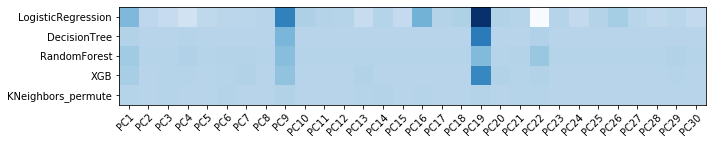

In [157]:
##### Navigating individual covariate levels and their factor importance scores
### visualizing the feature importance using a heatmap
import seaborn as sns
import pandas as pd
import dataframe_image as dfi
import seaborn as sns
import pandas as pd
import dataframe_image as dfi
### visualizing the feature importance using a heatmap
import seaborn as sns
import pandas as pd
import dataframe_image as dfi


covariate_name =  'protocol'#'cell_line'
factor_scores = pca_scores_rot
cov_level_feature_df_dict = {}

y_label = data.obs[covariate_name]

##### saving the importance of each covariate level in a dictionary
for covariate_level in y_label.unique():
    a_binary_cov = get_binary_covariate(covariate_name, covariate_level, data)
    factor_scores = pca_scores_rot
    cov_level_feature_df_dict[covariate_level] = get_importance_df(factor_scores, a_binary_cov)


a_cov_match_factor_dict = {}
a_cov_match_factor_dict_all = {}

for covariate_level in cov_level_feature_df_dict:
    importance_df = cov_level_feature_df_dict[covariate_level]
    print(covariate_level)
    #dfi.export(importance_df.style.background_gradient(cmap='Blues', axis=1 ), '/home/delaram/scLMM/feature_heatmap_images/imp_heatmap_'+ covariate_level+'.png')
    
    ## identify the column (PC) with max value in each row (ML model)
    match_factor_table = importance_df.idxmax(axis='columns')
    highest_vote_factor = str(list(match_factor_table.mode())[0])
    print('Highest scoring factor in each model for \"'+ str(covariate_level)+ '\":\n', match_factor_table.to_frame(name=''), '\n')
    
    print('Highest factor for \"'+ str(covariate_level)+ '\" based on voting: ', str(highest_vote_factor))

    a_cov_match_factor_dict[covariate_level] = highest_vote_factor
    a_cov_match_factor_dict_all[covariate_level] = match_factor_table.to_frame(name='')


covariate_level = list(cov_level_feature_df_dict.keys())[2]
print(covariate_level)
print(highest_vote_factor)
importance_df = cov_level_feature_df_dict[covariate_level]
#importance_df.style.background_gradient(cmap='Blues', axis=1 )

### visualizing the feature importance using a heatmap
importance_df_np = np.asarray(importance_df)
### plot the heatmap
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(importance_df_np, cmap='Blues')
### add the labels
ax.set_xticks(np.arange(len(importance_df.columns)))
ax.set_yticks(np.arange(len(importance_df.index)))
ax.set_xticklabels(importance_df.columns)
ax.set_yticklabels(importance_df.index)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
### add the colorbar
#cbar = ax.figure.colorbar(im, ax=ax)
#cbar.ax.set_ylabel('Importance', rotation=-90, va="bottom")
### show the plot
fig.tight_layout()
plt.show()

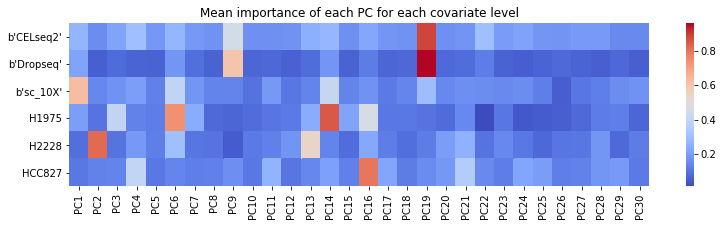

In [156]:
mean_importance_df_protocol.shape
mean_importance_df_cell_line

### concatenate mean_importance_df_protocol and mean_importance_df_cell_line
mean_importance_df = pd.concat([mean_importance_df_protocol, mean_importance_df_cell_line], axis=0)
mean_importance_df.shape
### plot mean_importance_df as a heatmap
fig, ax = plt.subplots(figsize=(13, 3))
sns.heatmap(mean_importance_df, cmap='coolwarm', ax=ax)
ax.set_title('Mean importance of each PC for each covariate level')
plt.show()


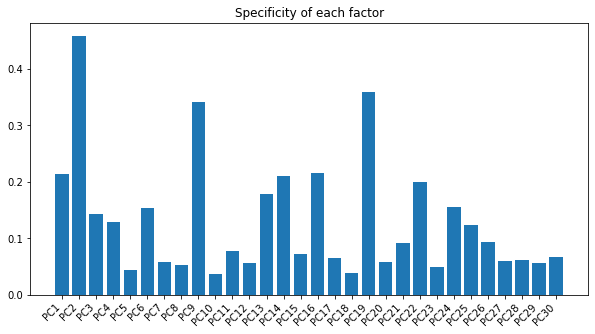

In [167]:
### scale the mean_importance_df base on column so that each column is between 0 and 1

### calculating specificity of a single factor
def get_factor_specificity(factor_i, mean_importance_df, p_all_factors):
    p_factor_i = p_all_factors[factor_i]
    S_factor = 0 
    for lev in range(mean_importance_df.shape[0]):
        p_factor_lev = mean_importance_df.iloc[lev, factor_i]
        S_factor += (p_factor_lev/p_factor_i)*np.log(p_factor_lev/p_factor_i)
    return S_factor/mean_importance_df.shape[0]


def get_all_factors_specificity(mean_importance_df):
    factor_specificity_all = []
    p_all_factors = np.sum(np.asarray(mean_importance_df), axis=0)/mean_importance_df.shape[0]
    for factor_i in range(mean_importance_df.shape[1]):
        S_factor = get_factor_specificity(factor_i, mean_importance_df, p_all_factors)
        factor_specificity_all.append(S_factor)
    return factor_specificity_all

factor_specificity_all = get_all_factors_specificity(mean_importance_df)


### plot the factor specificity as a bar plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(range(len(factor_specificity_all)), factor_specificity_all)
ax.set_xticks(range(len(factor_specificity_all)))
ax.set_xticklabels(mean_importance_df.columns, rotation=45, ha="right",)
ax.set_title('Specificity of each factor')
plt.show()


In [98]:

### print the levels of the protocol metadata ['sc_10X' 'CELseq2' 'Dropseq']
# print the levels of the cell line metadata ['HCC827' 'H1975' 'H2228']

### generating the list of colors for samples
my_color = {b'sc_10X': 'palegreen', b'CELseq2':'yellow', b'Dropseq':'pink'}
### generate a list containing the corresponding color for each sample
protocol_color = [my_color[y_protocol[i]] for i in range(len(y_protocol))]

my_color = {'HCC827': 'springgreen', 'H1975':'red', 'H2228':'orchid'}
cell_line_color = [my_color[y_cell_line[i]] for i in range(len(y_cell_line))]


print(a_cov_match_factor_dict)

{b'sc_10X': 'PC1', b'CELseq2': 'PC19', b'Dropseq': 'PC19'}


b'sc_10X' PC1


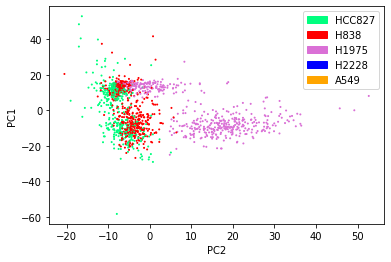

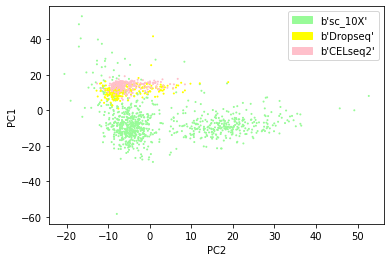

In [104]:
print(covariate_level, a_cov_match_factor_dict[covariate_level])
        
highest_vote_factor = a_cov_match_factor_dict[covariate_level]
i = int(highest_vote_factor[2:]) - 1
plt.figure()
plt.scatter(pca_scores_rot[:,1], pca_scores_rot[:,i], c=cell_line_color, s=1) 
plt.xlabel('PC2')
plt.ylabel('PC'+str(i+1))
plt.legend(handles=[mpatches.Patch(color='springgreen', label='HCC827'),
            mpatches.Patch(color='red', label='H838'),
            mpatches.Patch(color='orchid', label='H1975'),
            mpatches.Patch(color='blue', label='H2228'),
            mpatches.Patch(color='orange', label='A549')])


plt.show()
#plt.savefig('/home/delaram/scLMM/feature_heatmap_images/PCAplot_match_'+ covariate_level+'_c_cell_line.png')


plt.figure()
plt.scatter(pca_scores_rot[:,1], pca_scores_rot[:,i], c=protocol_color, s=1)
plt.xlabel('PC2')
plt.ylabel('PC'+str(i+1))
plt.legend(handles=[mpatches.Patch(color='palegreen', label=b'sc_10X'),
    mpatches.Patch(color='yellow', label=b'Dropseq'),
    mpatches.Patch(color='pink', label= b'CELseq2')], loc='best')
plt.show()


[457.7025664107307, 449.04046267869893, 362.5678510309681, 446.8720861626566, 432.94773717599173, 467.13048135504766, 475.6852274826582, 482.53180971472, 406.95489904254873, 463.48857543562934, 479.7406915284615, 263.41837425386166, 329.8565809354299, 468.9269548066539, 476.3272816377119, 235.17458743624803, 290.535707350048, 421.3762870631776, 114.42265195650413, 440.40747769198623, 440.83155824106734, 372.77137949547574, 422.06114727897153, 484.43765447801775, 412.079722687233, 466.68041995604534, 439.9949111003024, 258.98065039528313, 438.0835965801115, 424.5391894944444]


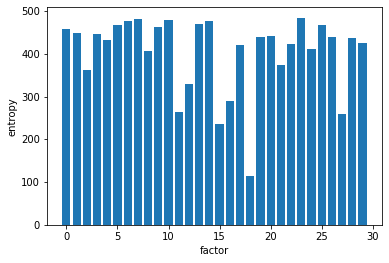

In [91]:

def get_factor_entropy(a_factor):
    ### caculate number of zeros in pk
    num_zeros = np.count_nonzero(a_factor == 0)
    #print('num_zeros: ', num_zeros)
    ### shift all the values to be positive
    a_factor = a_factor - np.min(a_factor) + 1e-10
    ### devide all the score by the max value
    a_factor = a_factor / np.max(a_factor)
    #plt.hist(a_factor, bins=100)
    H = -sum(a_factor * np.log(a_factor))
    #print('H: ', H)
    return H

def get_factor_entropy_all(pca_scores):
    ### calculate the entropy of all the factors
    H_all = []
    for i in range(num_components):
        a_factor = pca_scores[:,i]
        H = get_factor_entropy(a_factor)
        H_all.append(H)
    return H_all
    
i = 0 
a_factor = pca_scores[:,i]

factor_entropy_all = get_factor_entropy_all(pca_scores)
print(factor_entropy_all)
### plot the entropy of all the factors as a bar plot
plt.bar(range(num_components), factor_entropy_all)
plt.xlabel('factor')
plt.ylabel('entropy')
plt.show()


[0.6449179656579141, 0.07382513317013464, 0.030224635996968792]
[0.6449179656579141, 0.07382513317013464, 0.030224635996968792]
[0.6449179656579141, 0.07382513317013464, 0.030224635996968792]
[1.2543790062745215, 0.1853233696690762, 0.10895287218688691]
[0.2557716227497128, 2.6524452759483075, 0.8006961682189688]
[1.113240145177832, 0.13915675537051264, 0.19059623200459633]
[1.22637223204511, 0.45076675290519486, 0.6264983142726079]
[1.216640964852962, 0.15948346896116997, 0.11742563080615696]
[0.9689331545524552, 0.12567951034581137, 0.09705611016725761]
[1.0411101016835929, 1.0361727236329117, 0.6667558601999903]
[0.11653872411341255, 0.4818686670015282, 2.635145754018992]
[1.0522132872795353, 1.0155174261892352, 0.7501216337348291]
[1.1215714080127082, 0.4939093534446231, 0.5541462620559329]
[1.3406489247719993, 0.26868222888309945, 0.12600900259679293]
[0.4142161058536283, 2.59914374976348, 0.539282287620593]
[1.227404006931651, 0.09654766655540908, 0.20211352521014686]
[1.29591819

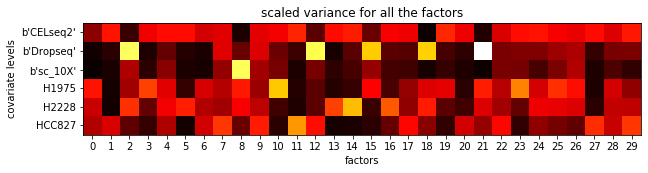

In [92]:
### calculate the scaled variance of one factor and one covariate 

def get_scaled_variance_level(a_factor, covariate_vector, covariate_level):
    a_factor_subset = a_factor[covariate_vector == covariate_level] ### select the cells in a_factor that belong to the covariate level
    scaled_variance = np.var(a_factor_subset)/np.var(a_factor) ### scaled variance of a factor and a covariate level
    return scaled_variance

### calculate the scaled variance for all the levels in a covariate 
### represents how well mixed the factor is across each level of the covariate. 1 is well mixed, 0 is not well mixed
def get_SV_all_levels(a_factor, covariate_vector):
    ### calculate the scaled variance for all the levels in a covariate
    scaled_variance_all = []
    for covariate_level in covariate_vector.unique():
        scaled_variance = get_scaled_variance_level(a_factor, covariate_vector, covariate_level)
        scaled_variance_all.append(scaled_variance)
        
    print(scaled_variance_all)
    return scaled_variance_all



### calculate an average for the relative scaled variance for all the levels in a covariate
def get_a_factor_ASV(a_factor, covariate_vector):
    ### calculate the relative scaled variance for all the levels in a covariate
    scaled_variance_all = get_SV_all_levels(a_factor, covariate_vector)
    RSV = sum(scaled_variance_all)/len(np.unique(covariate_vector)) ### sum of the scaled variance for all levels of the covariate / number of levels in the covariate
    return RSV

def get_ASV_all(pca_scores, covariate_vector):
    ASV_all = []
    for i in range(num_components):
        a_factor = pca_scores[:,i]
        ASV = get_a_factor_ASV(a_factor, covariate_vector)
        ASV_all.append(ASV)
    return ASV_all

def get_factors_SV_all_levels(pca_scores, covariate_vector):
    SV_all_factors = []
    for i in range(num_components):
        a_factor = pca_scores[:,i]
        SV_all = get_SV_all_levels(a_factor, covariate_vector)
        
        SV_all_factors.append(SV_all)
    SV_all_factors = np.asarray(SV_all_factors)
    return SV_all_factors.T ### traspose the matrix to have the factors in columns and cov levels in rows



covariate_level = b'sc_10X'
covariate_vector = y_protocol

SV_level = get_scaled_variance_level(a_factor, covariate_vector, covariate_level)
SV_all = get_SV_all_levels(a_factor, covariate_vector)
a_factor_ASV_protocol = get_a_factor_ASV(a_factor, y_protocol)

ASV_protocol_all = get_ASV_all(pca_scores, y_protocol)
ASV_cell_line_all = get_ASV_all(pca_scores, y_cell_line)

print('SV_level: ', SV_level)
print('SV_all: ', SV_all)
print('RSV: ', a_factor_ASV_protocol)

#### calculate the scaled variance for all the factors
SV_all_factors_protocol = get_factors_SV_all_levels(pca_scores, covariate_vector)
covariate_vector = y_cell_line
SV_all_factors_cell_line = get_factors_SV_all_levels(pca_scores, covariate_vector)

### concatenate the two matrices
SV_all_factors = np.concatenate((SV_all_factors_protocol, SV_all_factors_cell_line), axis=0)

print('SV_all_factors: ', SV_all_factors.shape) 
### plot the scaled variance for all the factors
plt.figure(figsize=(10, 10))
plt.imshow(SV_all_factors, cmap='hot', interpolation='nearest')


## concatenate the unique values of the two covariates
all_covariate_levels = np.concatenate((np.unique(y_protocol), np.unique(y_cell_line)), axis=0)
print(all_covariate_levels)

### add the labels of factors and covariate leveles to the plot
plt.xticks(np.arange(num_components), np.arange(num_components))
plt.yticks(np.arange(len(all_covariate_levels)), all_covariate_levels)


### make the plot look nice
#plt.colorbar()
plt.xlabel('factors')
plt.ylabel('covariate levels')
plt.title('scaled variance for all the factors')

### add a small horizontal legend
plt.show()


[0.7227872731361246, 0.7713414261471386, 0.7054899419569578, 0.6235152750305545, 0.5648601885636736, 0.7348257168793698, 0.640830816527096, 0.6552026633746892, 0.7983912010977113, 0.5657120517514933, 0.76157716972259, 0.7784800887992749, 0.6423945831855387, 0.750174350913116, 0.7882422703364484, 0.6795500486335898, 0.5839520800652227, 0.6056703223790092, 0.779135763589272, 0.6193073337734656, 0.6750794906596431, 0.8103271780322585, 0.552703672471576, 0.6298657937544299, 0.599637981903674, 0.5385661829176789, 0.564961611340878, 0.6868285096291437, 0.5878058004082084, 0.6037933288183084]


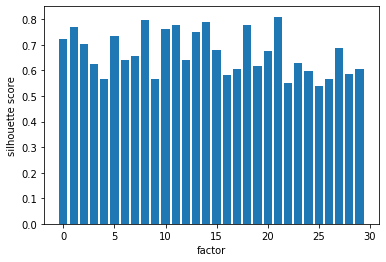

In [93]:
import sklearn.cluster as cluster
from sklearn import metrics

def get_silhouette_score(a_factor, kmeans_labels):
    a_factor_silhouette_score = metrics.silhouette_score(a_factor.reshape(-1, 1), kmeans_labels, metric='euclidean')
    return a_factor_silhouette_score

### apply kmeans to all the factors independently
def get_kmeans_silhouette_scores(pca_scores):
    silhouette_score_all = []
    for i in range(num_components):
        kmeans = cluster.KMeans(n_clusters=2, random_state=0).fit(pca_scores[:,i].reshape(-1, 1))
        a_factor_silhouette_score = get_silhouette_score(pca_scores[:,i], kmeans.labels_)
        silhouette_score_all.append(a_factor_silhouette_score)
        #kmeans_all.append(kmeans.labels_)
    return silhouette_score_all


silhouette_score_all = get_kmeans_silhouette_scores(pca_scores)
print(silhouette_score_all)
### plot the silhouette score for all the factors
plt.bar(range(num_components), silhouette_score_all)
plt.xlabel('factor')
plt.ylabel('silhouette score')
plt.show()

[153.23131571235257, 124.87974354183928, 132.94447421945495, 116.553744074506, 95.51447146947329, 233.45514751577215, 77.23582466260991, 77.00337552850286, 66.35868283732374, 54.14330987022462, 62.20857391346369, 51.39672604535519, 162.41319430428456, 193.9438069526594, 40.8888541867269, 143.83394167327899, 52.229004658238324, 50.804528176801654, 97.90331367255243, 61.073116026672565, 170.10123496738305, 34.31682070962825, 44.118220204238376, 31.322102793538136, 25.324917991029064, 22.39222666343876, 83.42919007503652, 55.16095367360298, 37.15842108879141, 19.601641184380085]


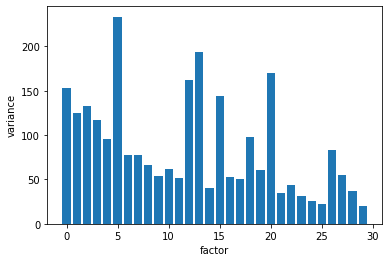

In [94]:
def get_factor_variance_all(pca_scores):
    factor_variance_all = []
    for i in range(num_components):
        a_factor = pca_scores[:,i]
        factor_variance = np.var(a_factor)
        factor_variance_all.append(factor_variance)
    return factor_variance_all

factor_variance_all = get_factor_variance_all(pca_scores)
print(factor_variance_all)
### plot the variance for all the factors
plt.bar(range(num_components), factor_variance_all)
plt.xlabel('factor')
plt.ylabel('variance')
plt.show()


[0.6449179656579141, 0.07382513317013464, 0.030224635996968792]
[1.2543790062745215, 0.1853233696690762, 0.10895287218688691]
[0.2557716227497128, 2.6524452759483075, 0.8006961682189688]
[1.113240145177832, 0.13915675537051264, 0.19059623200459633]
[1.22637223204511, 0.45076675290519486, 0.6264983142726079]
[1.216640964852962, 0.15948346896116997, 0.11742563080615696]
[0.9689331545524552, 0.12567951034581137, 0.09705611016725761]
[1.0411101016835929, 1.0361727236329117, 0.6667558601999903]
[0.11653872411341255, 0.4818686670015282, 2.635145754018992]
[1.0522132872795353, 1.0155174261892352, 0.7501216337348291]
[1.1215714080127082, 0.4939093534446231, 0.5541462620559329]
[1.3406489247719993, 0.26868222888309945, 0.12600900259679293]
[0.4142161058536283, 2.59914374976348, 0.539282287620593]
[1.227404006931651, 0.09654766655540908, 0.20211352521014686]
[1.2959181982537509, 0.4037167003029987, 0.3177777496950281]
[0.4815464728084564, 2.125260179746185, 0.6863248133002291]
[1.148442141562774

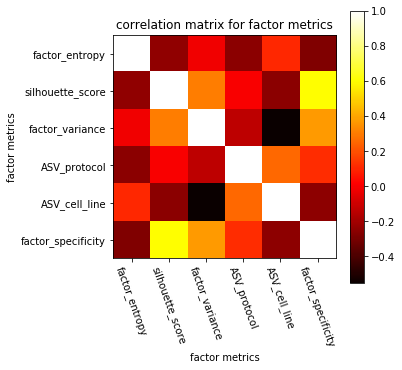

In [169]:
#### label free factor metrics
factor_entropy_all = get_factor_entropy_all(pca_scores)
silhouette_score_all = get_kmeans_silhouette_scores(pca_scores)
factor_variance_all = get_factor_variance_all(pca_scores)


### label dependent factor metrics
ASV_protocol_all = get_ASV_all(pca_scores, y_protocol)
ASV_cell_line_all = get_ASV_all(pca_scores, y_cell_line)
factor_specificity_all = get_all_factors_specificity(mean_importance_df)


### concatenate all matrices
all_metrics = np.concatenate((np.asarray(factor_entropy_all).reshape(-1, 1), 
                              np.asarray(silhouette_score_all).reshape(-1, 1), 
                              np.asarray(factor_variance_all).reshape(-1, 1), 
                              np.asarray(ASV_protocol_all).reshape(-1, 1), 
                              np.asarray(ASV_cell_line_all).reshape(-1, 1),
                              np.asarray(factor_specificity_all).reshape(-1, 1)), axis=1)

factor_metrics = ['factor_entropy', 'silhouette_score', 'factor_variance', 'ASV_protocol', 'ASV_cell_line', 'factor_specificity']
print(all_metrics.shape)
### calculate the correlation matrix
corr = np.corrcoef(all_metrics.T)
print(corr.shape)
### plot the correlation matrix with hierarchical clustering
plt.figure(figsize=(5, 5))
plt.imshow(corr, cmap='hot', interpolation='nearest')
plt.xticks(np.arange(len(factor_metrics)), factor_metrics, rotation=-70)
plt.yticks(np.arange(len(factor_metrics)), factor_metrics)
plt.colorbar()
plt.xlabel('factor metrics')
plt.ylabel('factor metrics')
plt.title('correlation matrix for factor metrics')
plt.show()

